## 2024 CVE Data

In [1]:
%%capture
!rm nvd.jsonl
!wget -q https://nvd.handsonhacking.org/nvd.jsonl

In [52]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import warnings
import calplot
from itables import init_notebook_mode, show
import itables.options as opt

opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [53]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            try: 
                vulnStatus = entry['cve']['vulnStatus']
            except IndexError:
                vulnStatus = ''  
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner,
                'Status': vulnStatus 
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2025-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2024, 1, 1)
enddate  = date(2025,1,1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [54]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **40009**<br />Average CVEs Per Day: **109.31**<br />Average CVSS Score: **6.68**

In [55]:
Markdown(f"## CVE Graphs")

## CVE Graphs

In [56]:
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

In [57]:
Markdown(f"### CVE Calendar")

### CVE Calendar

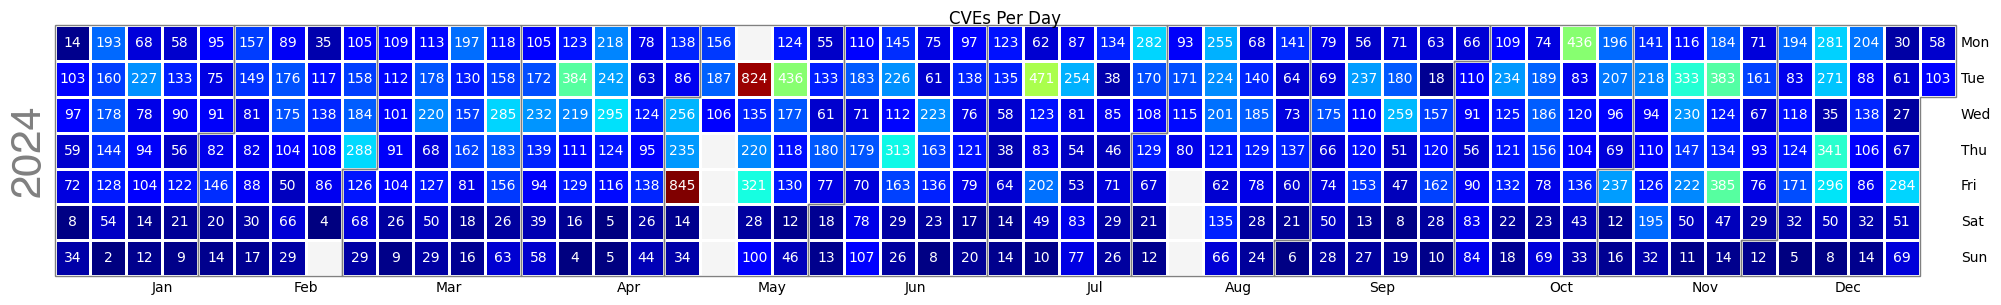

In [58]:
dfs = nvd['Published'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
calplot.calplot(df.T.squeeze(), cmap='jet', dropzero=True, edgecolor="Grey", textcolor="White", textformat='{:.0f}', textfiller='', suptitle='CVEs Per Day', figsize=(25,3));

#### Per Month

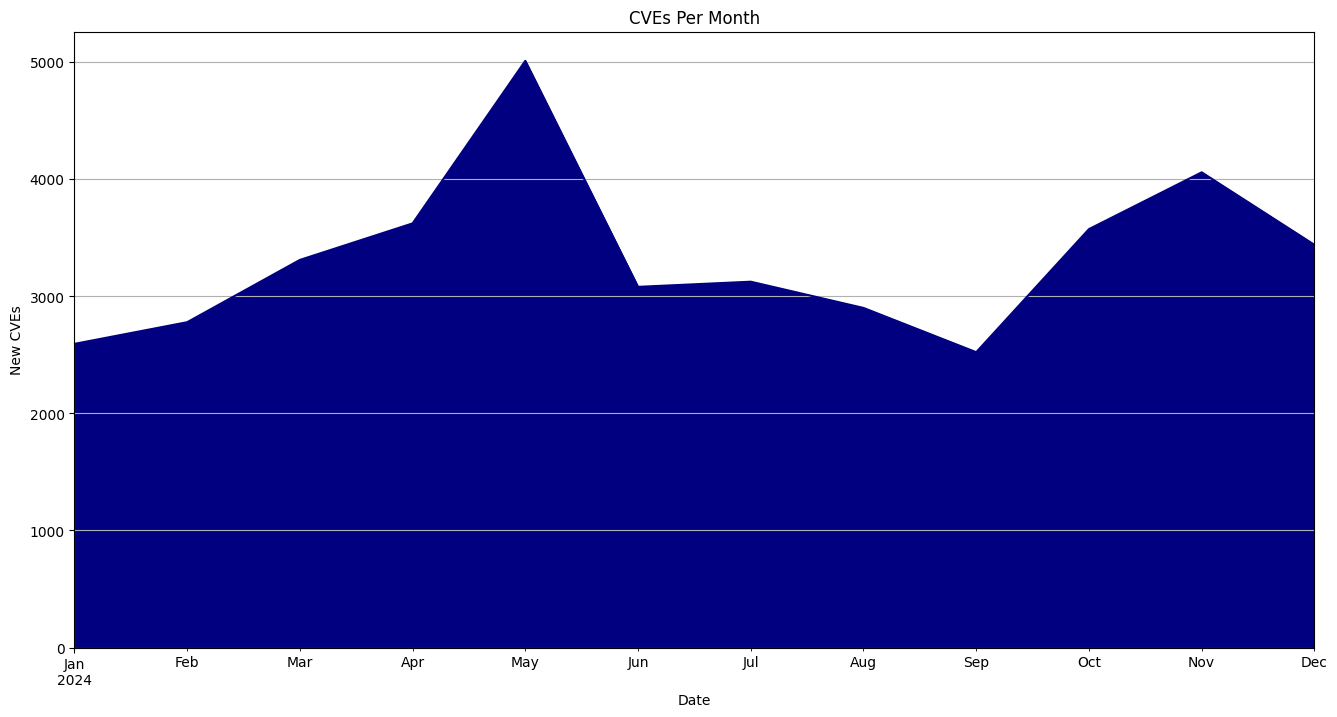

In [59]:
cg = Month_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Month')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");
plt.savefig('All.jpg', dpi=300, bbox_inches='tight')

In [60]:
Markdown(f"### CVE Per Week Graph")

### CVE Per Week Graph

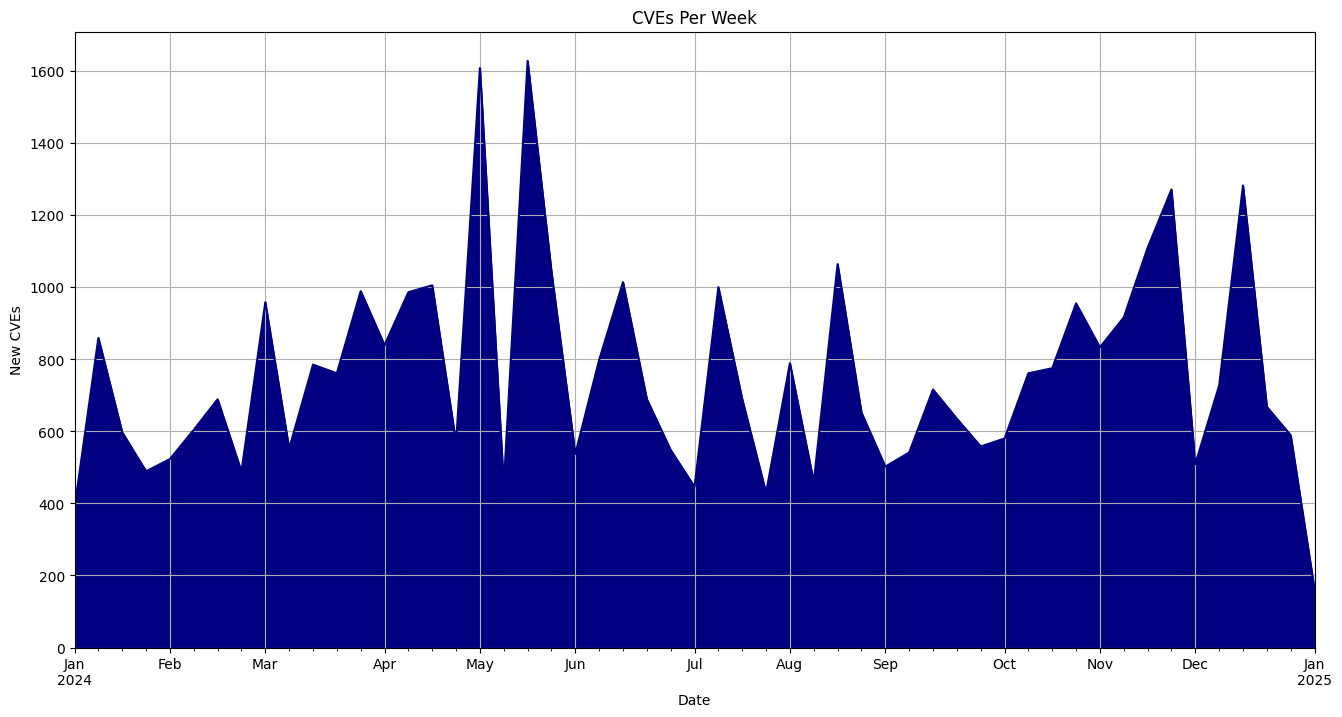

In [61]:

cg = Week_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Week')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

In [62]:
Markdown(f"### CVE Per Day Graph")

### CVE Per Day Graph

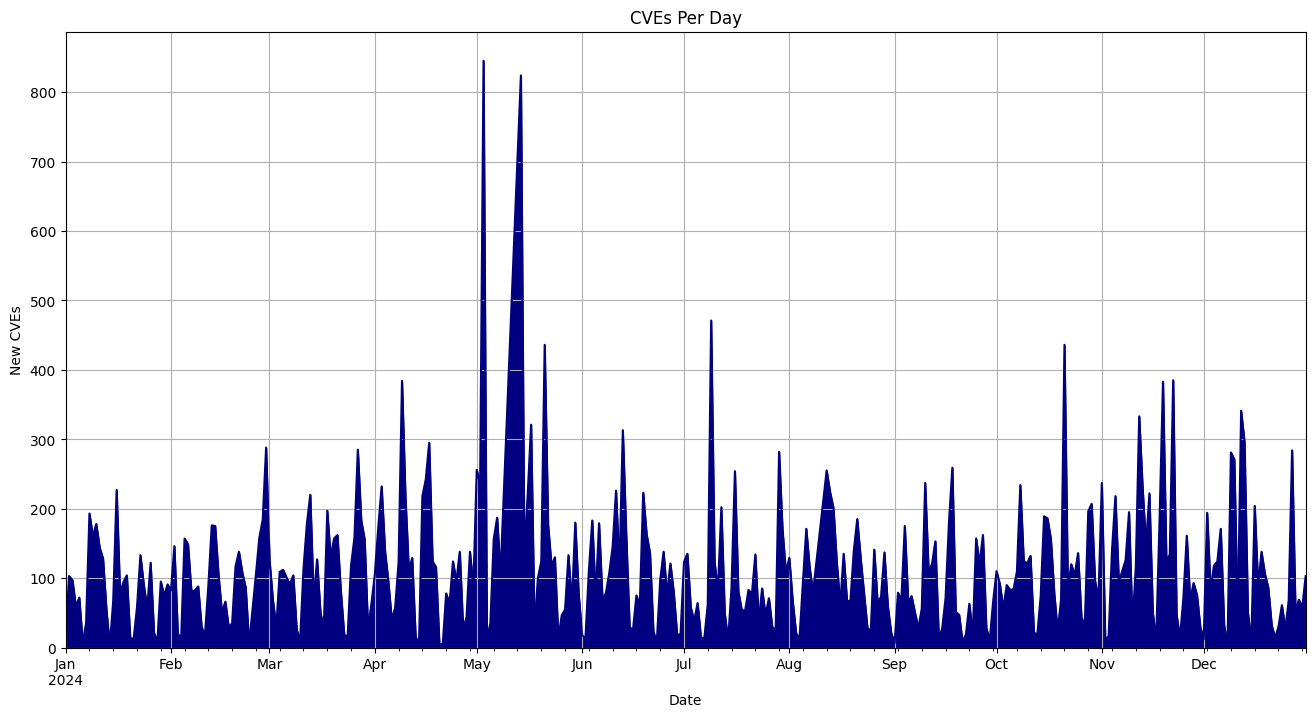

In [63]:

cg = Day_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

In [64]:
Markdown(f"## CVSS Data")

## CVSS Data

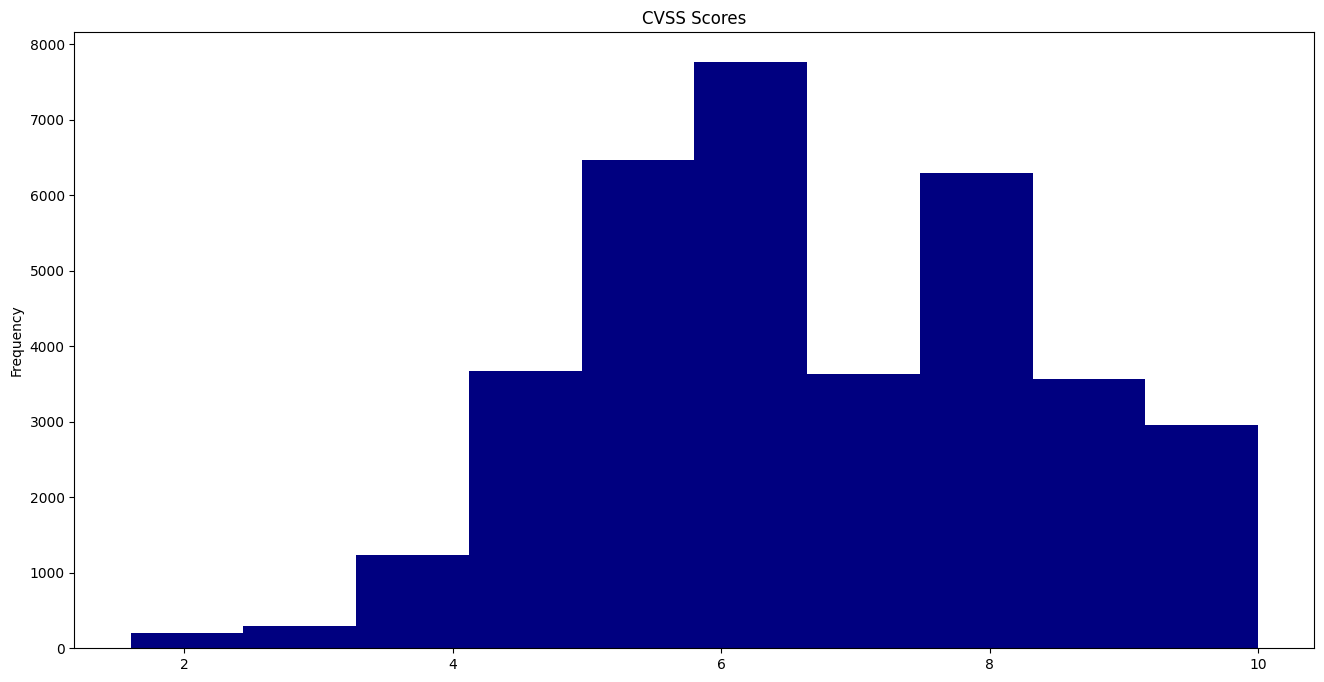

In [65]:
nvd['BaseScore'].plot(kind="hist", colormap='jet', figsize=(16, 8), title='CVSS Scores');

In [66]:
Markdown(f"## CNA Data")

## CNA Data

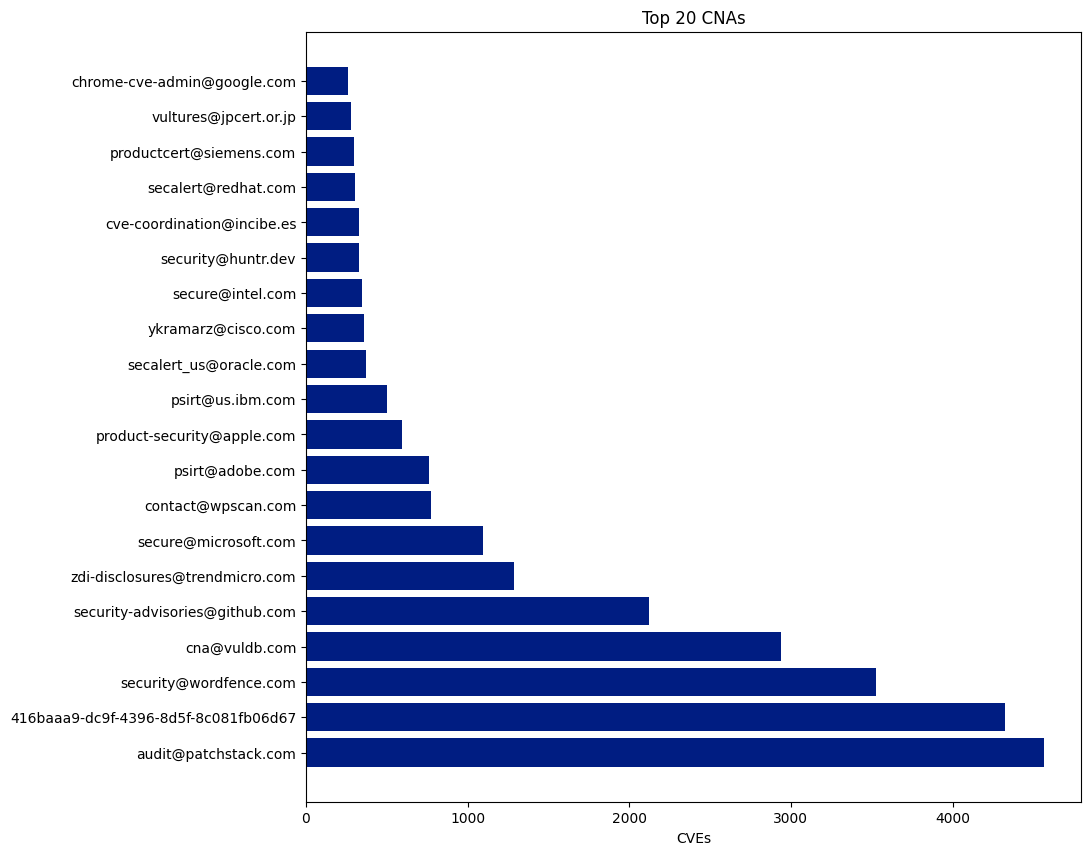

In [67]:
Markdown(f"### CNA Assigner Graph")
nvd_frequency = nvd['Assigner'].value_counts()
nvd_frequency = nvd_frequency.reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency[nvd_frequency.counts > 100].head(50)
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('cve@mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre.head(20)
plt.figure(figsize=(10,10))
plt.barh("Assigner", "counts", data = nvd_frequency_no_mitre, color="#001d82")
plt.xlabel("CVEs"); 
plt.ylabel("") ;
plt.title("Top 20 CNAs");


In [68]:
Markdown(f"## CWE Data")

## CWE Data

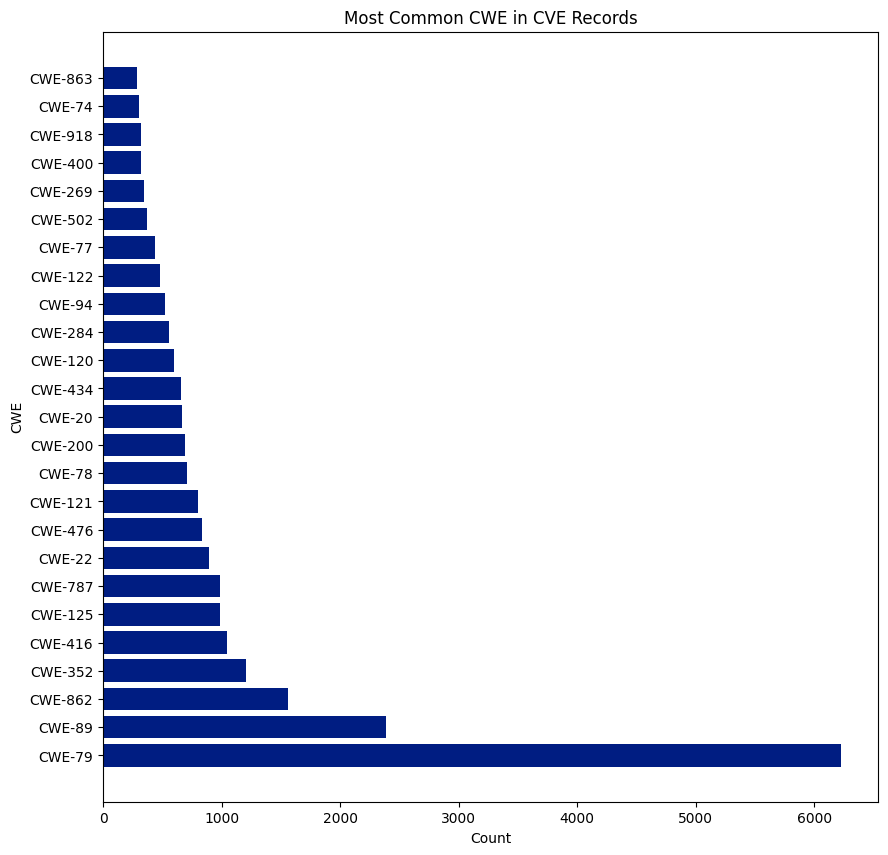

In [69]:
nvd_cwe = nvd['CWE'].value_counts()
nvd_cwe = nvd_cwe.reset_index()
nvd_cwe.columns = ['CWE', 'counts']
nvd_cwe = nvd_cwe[~nvd_cwe.CWE.str.contains('Missing_')]
nvd_cwe = nvd_cwe[~nvd_cwe.CWE.str.contains('NVD')]
nvd_cwe = nvd_cwe.head(25)
plt.figure(figsize=(10,10));
plt.barh("CWE", "counts", data = nvd_cwe, color="#001d82");
plt.xlabel("Count"); 
plt.ylabel("CWE") ;
plt.title("Most Common CWE in CVE Records");


In [70]:
Markdown(f"## More CVE Data")

## More CVE Data

In [71]:
Markdown(f"### Top CNA Assigner")

### Top CNA Assigner

In [72]:
nvd_frequency_no_mitre

Assigner  counts
1                   audit@patchstack.com    4566
2   416baaa9-dc9f-4396-8d5f-8c081fb06d67    4325
3                 security@wordfence.com    3525
4                          cna@vuldb.com    2936
5         security-advisories@github.com    2121
6         zdi-disclosures@trendmicro.com    1286
7                   secure@microsoft.com    1095
8                     contact@wpscan.com     773
9                        psirt@adobe.com     760
10            product-security@apple.com     596
11                      psirt@us.ibm.com     504
12                secalert_us@oracle.com     370
13                    ykramarz@cisco.com     361
14                      secure@intel.com     348
15                    security@huntr.dev     328
16            cve-coordination@incibe.es     325
17                   secalert@redhat.com     306
18               productcert@siemens.com     295
19                 vultures@jpcert.or.jp     281
20           chrome-cve-admin@google.com     261

In [73]:
Markdown(f"### CVEs By Identifier")

### CVEs By Identifier

In [74]:

print("CVE-1999-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-1999-')]))
print("CVE-2000-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2000-')]))
print("CVE-2001-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2001-')]))
print("CVE-2002-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2002-')]))
print("CVE-2003-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2003-')]))
print("CVE-2004-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2004-')]))
print("CVE-2005-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2005-')]))
print("CVE-2006-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2006-')]))
print("CVE-2007-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2007-')]))
print("CVE-2008-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2008-')]))
print("CVE-2009-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2009-')]))
print("CVE-2010-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2010-')]))
print("CVE-2011-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2011-')]))
print("CVE-2012-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2012-')]))
print("CVE-2013-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2013-')]))
print("CVE-2014-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2014-')]))
print("CVE-2015-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2015-')]))
print("CVE-2016-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2016-')]))
print("CVE-2017-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2017-')]))
print("CVE-2018-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2018-')]))
print("CVE-2019-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2019-')]))
print("CVE-2020-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2020-')]))
print("CVE-2021-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2021-')]))
print("CVE-2022-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2022-')]))
print("CVE-2023-\t%s" % len(nvd[nvd['CVE'].str.contains('CVE-2023-')]))

CVE-1999-	0
CVE-2000-	0
CVE-2001-	0
CVE-2002-	0
CVE-2003-	0
CVE-2004-	0
CVE-2005-	1
CVE-2006-	0
CVE-2007-	0
CVE-2008-	0
CVE-2009-	0
CVE-2010-	1
CVE-2011-	2
CVE-2012-	2
CVE-2013-	0
CVE-2014-	3
CVE-2015-	7
CVE-2016-	10
CVE-2017-	30
CVE-2018-	112
CVE-2019-	38
CVE-2020-	139
CVE-2021-	905
CVE-2022-	790
CVE-2023-	5264


In [75]:
Markdown(f"### First 5 CVEs")

### First 5 CVEs

In [79]:
nvd[["CVE", "Description"]].head(5)

CVE                                        Description
0  CVE-2024-21732  FlyCms through abbaa5a allows XSS via the perm...
1   CVE-2023-5877  The affiliate-toolkit WordPress plugin before ...
2   CVE-2023-6000  The Popup Builder WordPress plugin before 4.2....
3   CVE-2023-6037  The WP TripAdvisor Review Slider WordPress plu...
4   CVE-2023-6064  The PayHere Payment Gateway WordPress plugin b...

In [80]:
Markdown(f"### Last 5 CVEs")

### Last 5 CVEs

In [82]:

nvd[["CVE", "Description"]].tail(5)

CVE                                        Description
40004  CVE-2024-13084  A vulnerability classified as critical was fou...
40005  CVE-2024-13085  A vulnerability, which was classified as criti...
40006  CVE-2024-56062  Improper Neutralization of Input During Web Pa...
40007  CVE-2024-56063  Improper Neutralization of Input During Web Pa...
40008  CVE-2024-56803  Ghostty is a cross-platform terminal emulator....